### Load models


In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import rc

sys.path.append("../")
# Import dataloaders
import data_utils.ood_detection.cifar10 as cifar10
import data_utils.ood_detection.cifar100 as cifar100
import data_utils.ood_detection.lsun as lsun
import data_utils.ood_detection.svhn as svhn
import data_utils.ood_detection.mnist as mnist
import data_utils.ood_detection.tiny_imagenet as tiny_imagenet

# Network architectures
from net.lenet import lenet
from net.resnet import resnet50
from net.vgg import vgg16
from net.wide_resnet import wrn

from utils.gmm_utils import get_embeddings, gmm_evaluate, gmm_fit, maxp_evaluate, gmm_evaluate_with_perturbation,gmm_evaluate_with_perturbation3, maxp_evaluate_with_perturbation
from metrics.uncertainty_confidence import entropy, logsumexp, confidence, sumexp, maxval
from metrics.ood_metrics import get_roc_auc, get_roc_auc_logits

In [120]:
device = torch.device("cuda:1")
# Dataset params
dataset_num_classes = {"cifar10": 10, "CIFAR100": 100, "SVHN": 10, "LSUN": 10, "tiny_iamgenet": 200}

dataset_loader = {"cifar10": cifar10, "CIFAR100": cifar100, "SVHN": svhn, "MNIST": mnist, "LSUN": lsun, "tiny_imagenet": tiny_imagenet}

# Mapping model name to model function
models = {
    "lenet": lenet,
    "resnet50": resnet50,
    "wide_resnet": wrn,
    "vgg16": vgg16,
}

model_to_num_dim = {"resnet18": 512, "resnet50": 2048, "resnet101": 2048, "resnet152": 2048, "wide_resnet": 640, "vgg16": 512}

batch_size = 512
dataset = "cifar10"
ood_dataset = "MNIST"
dataset_root = "../data"
# model = "vgg16"
# saved_model_name = "../saved_models/run38/vgg16_sn_3.0_mod_seed_1/2024_11_26_01_05_50/vgg16_sn_3.0_mod_seed_1_best.model"

model = "resnet50"
saved_model_name = "../saved_models/run38/resnet50_sn_3.0_mod_seed_1/2024_11_28_16_33_29/resnet50_sn_3.0_mod_seed_1_best.model"

# Taking input for the dataset
num_classes = dataset_num_classes[dataset]

In [45]:
train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
    root=dataset_root,
    batch_size=batch_size,
    augment=False,
    val_seed=1,
    val_size=0.1,
)

#load model
print(f"load {saved_model_name}")
net = models[model](
    spectral_normalization=True,
    mod=True,
    num_classes=num_classes,
    temp=1.0,
).to(device)

_ = net.load_state_dict(torch.load(str(saved_model_name), map_location=device), strict=True)
_ = net.eval()

load ../saved_models/run38/resnet50_sn_3.0_mod_seed_1/2024_11_28_16_33_29/resnet50_sn_3.0_mod_seed_1_best.model


In [46]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})

rc('text', usetex=False)


def plot_density(results, binrange, bins, title, xlabel):

    plt.figure(figsize=(5, 3))
    plt.tight_layout()

    plt.hist(results[0], density=True, color='r', range=binrange, bins=bins, alpha=0.5, label="org")
    plt.hist(results[1], density=True, color='b', range=binrange, bins=bins, alpha=0.5, label="ood")

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Fraction', fontsize=12)
    plt.title(label=title)
    plt.legend()


if not os.path.exists(f"pngs/{model}"):
    os.makedirs(f"pngs/{model}")

In [47]:
embeddings, labels, norm = get_embeddings(
    net,
    train_loader,
    num_dim=model_to_num_dim[model],
    dtype=torch.double,
    device=device,
    storage_device=device,
)
gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings, labels=labels, num_classes=num_classes)

get embeddings from dataloader...


100%|██████████| 88/88 [00:17<00:00,  5.16it/s]


In [48]:
def calculate_gradients_norm(
    net,
    gaussians_model,
    layer_name,
    loader,
    device,
    wrt="input",
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
    norm=1,
):
    layer_grad = None

    def bp_hook(module, grad_input, grad_output):
        # 获取中间层梯度信息
        nonlocal layer_grad
        input_grad = grad_input[0]
        w_grad = grad_input[1]
        # input_grad = grad_input[2]#TODO: 当使用sn时，conv层的bias都为false，这时候这样的,当bias为true时候，需要再次验证???
        if wrt == "input":
            layer_grad = torch.norm(input_grad, p=norm)  #1-norm
        elif wrt == "weight":
            layer_grad = torch.norm(w_grad, p=norm)  #1-norm

    norms = []

    std = torch.tensor(std).to(device)
    mean = torch.tensor(mean).to(device)
    loss_func = nn.CrossEntropyLoss()
    start = 0
    if layer_name in ["image"]:
        handler = net.conv1.register_backward_hook(bp_hook)
    elif layer_name in ['layer1', 'layer2', 'layer3']:
        handler = getattr(net, layer_name)[0].conv1.register_backward_hook(bp_hook)
    elif layer_name in ['fc']:
        handler = getattr(net, layer_name).register_backward_hook(bp_hook)
    cnt = 0
    for data, label in tqdm(loader, dynamic_ncols=True):
        data = data.to(device)
        label = label.to(device)

        data.requires_grad = True  #data.required_grad区分,用required_grad梯度为None
        out = net(data)
        uniform = torch.ones_like(out).to(device)
        _, pred = torch.max(out, 1)

        # #1. 第一种形式loss,log_density
        embedding = net.feature
        log_probs = gaussians_model.log_prob(embedding[:, None, :])
        max_log_probs = log_probs.max(1, keepdim=True)[0]  # get the index of the max log-probability
        loss = max_log_probs.sum()

        # # #2. 第二种形式loss,crossEntropy
        # loss = loss_func(out, pred)

        net.zero_grad()
        loss.backward()

        norms.append(layer_grad.cpu().detach())

        cnt += data.shape[0]
        if cnt > 1000:
            break

    return torch.tensor(norms)

### GradNorm as model uncertainty

In [ ]:
layer = "image"
wrt = "input"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1,sample_size=20000)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1,sample_size=20000)
gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    wrt=wrt,
    norm=1,
)
ood_gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)

right = int(max(gradient_norms.quantile(0.99).item(), ood_gradient_norms.quantile(0.99).item()))
m2_fpr95, m2_auroc, m2_auprc = get_roc_auc_logits(gradient_norms, ood_gradient_norms, None, device, conf=False)
print(f"grad norm for {layer}:m2_auroc:{m2_auroc},m2_auprc:{m2_auprc}")
plot_density([gradient_norms.numpy(), ood_gradient_norms.numpy()],
             binrange=[0, right + 50],
             bins=100,
             title=f"gradient distribution[layer:{layer},m2_auroc:{m2_auroc:.4f}]",
             xlabel="gradient norm")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_input_dist.png', bbox_inches='tight')

### Compute feature density


In [121]:
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=512,sample_size=1000)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=512,sample_size=1000)
logits, labels, preds = gmm_evaluate(
    net,
    gaussians_model,
    None,
    test_loader,
    device=device,
    num_classes=num_classes,
    storage_device=device,
)

ood_logits, ood_labels, _ = gmm_evaluate(
    net,
    gaussians_model,
    None,
    ood_test_loader,
    device=device,
    num_classes=num_classes,
    storage_device=device,
)
m1_fpr95, m1_auroc, m1_auprc = get_roc_auc_logits(logits, ood_logits, maxval, device, conf=True)

test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1,sample_size=1000)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1,sample_size=1000)
for epsilon in [0.001,0.01]:
    logits2, labels2, preds2, acc, acc_perturb = gmm_evaluate_with_perturbation(
        net,
        gaussians_model,
        test_loader,
        device=device,
        num_classes=num_classes,
        storage_device=device,
        perturbation="fgsm",
        epsilon=epsilon,
    )
    ood_logits2, ood_labels2, _, _, _ = gmm_evaluate_with_perturbation(
        net,
        gaussians_model,
        ood_test_loader,
        device=device,
        num_classes=num_classes,
        storage_device=device,
        perturbation="fgsm",
        epsilon=epsilon,
    )
    m2_fpr95, m2_auroc, m2_auprc = get_roc_auc_logits(logits2, ood_logits2, maxval, device, conf=True)
    print(f"noise-:m1_auroc:{m1_auroc:.4f},m1_auprc:{m1_auprc:.4f};noise+:epsilon:{epsilon},m2_auroc:{m2_auroc:.4f},m2_auprc:{m2_auprc:.4f}")

100%|██████████| 1000/1000 [01:52<00:00,  8.88it/s]


noise-:m1_auroc:0.9020,m1_auprc:0.9352;noise+:epsilon:0.001,m2_auroc:0.9307,m2_auprc:0.9483


100%|██████████| 1000/1000 [01:53<00:00,  8.83it/s]


noise-:m1_auroc:0.9020,m1_auprc:0.9352;noise+:epsilon:0.01,m2_auroc:0.9350,m2_auprc:0.9535


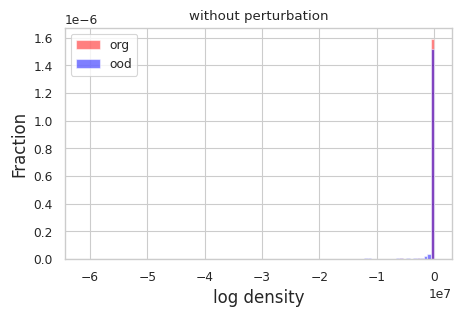

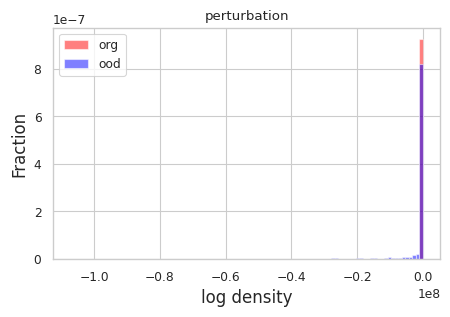

In [122]:
logp =  maxval(logits)
logp2 = maxval(logits2)
ood_logp = maxval(ood_logits)
ood_logp2 = maxval(ood_logits2)
left1 = int(min(logp.quantile(0.).item(), ood_logp.quantile(0.).item()))
right1 = int(max(logp.quantile(1).item(), ood_logp.quantile(1).item()))
plot_density([logp.cpu().numpy(), ood_logp.cpu().numpy()],
             binrange=[left1 - 100, right1 + 100],
             bins=100,
             title="without perturbation",
             xlabel="log density")
plt.savefig(f'pngs/{model}/logdensity_hist.png', bbox_inches='tight')
left2 = int(min(logp2.quantile(0).item(), ood_logp2.quantile(0.).item()))
right2 = int(max(logp2.quantile(1).item(), ood_logp2.quantile(1).item()))
plot_density([logp2.cpu().numpy(), ood_logp2.cpu().numpy()],
             binrange=[left2 - 100, right2 + 100],
             bins=100,
             title="perturbation",
             xlabel="log density")
plt.savefig(f'pngs/{model}/logdensity_hist_purturbation.png', bbox_inches='tight')

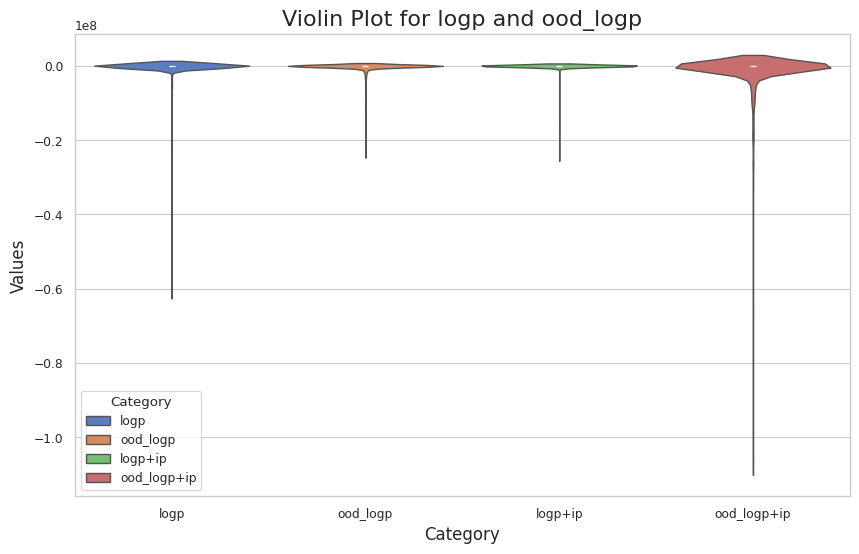

In [123]:
data = {
    "Values": np.concatenate([logp.cpu().numpy(),  ood_logp.cpu().numpy(),logp2.cpu().numpy(),ood_logp2.cpu().numpy()]),
    "Category": np.repeat(['logp', 'ood_logp', 'logp+ip', 'ood_logp+ip'],1000)
}
df = pd.DataFrame(data)

# 绘制小提琴图
plt.figure(figsize=(10, 6))
sns.violinplot(x='Category', y='Values', hue='Category', data=df, palette='muted', inner='box', legend=True)
# sns.boxplot(x='Category', y='Values', hue='Category',data=df, palette='muted')

# 添加标题和标签
plt.title('Violin Plot for logp and ood_logp', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Values', fontsize=12)

# 显示图表
plt.show()

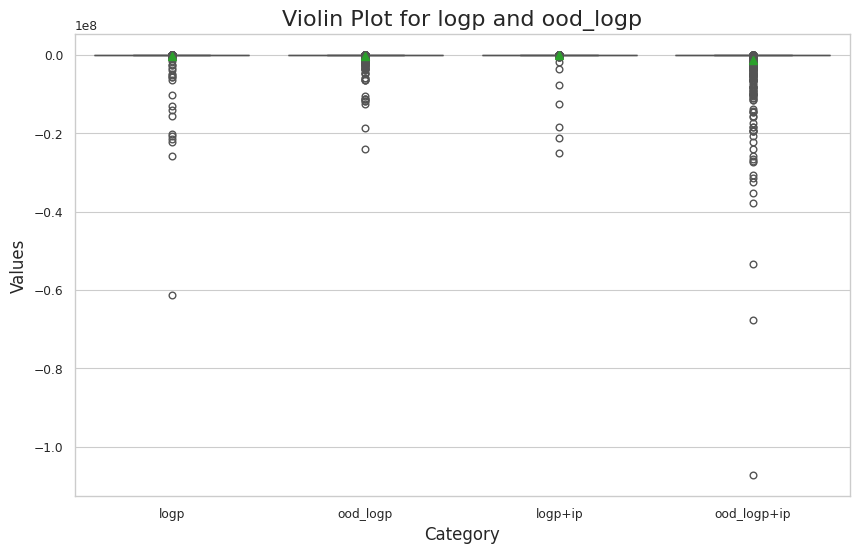

In [124]:
data = {
    "Values": np.concatenate([logp.cpu().numpy(),  ood_logp.cpu().numpy(),logp2.cpu().numpy(),ood_logp2.cpu().numpy()]),
    "Category": np.repeat(['logp', 'ood_logp', 'logp+ip', 'ood_logp+ip'],1000)
}
df = pd.DataFrame(data)

# 绘制小提琴图
plt.figure(figsize=(10, 6))
# sns.violinplot(x='Category', y='Values', hue='Category', data=df, palette='muted', inner='quartile', legend=False)
sns.boxplot(x='Category', y='Values', hue='Category',data=df, palette='muted',showmeans=True,)

# 添加标题和标签
plt.title('Violin Plot for logp and ood_logp', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Values', fontsize=12)

# 显示图表
plt.show()

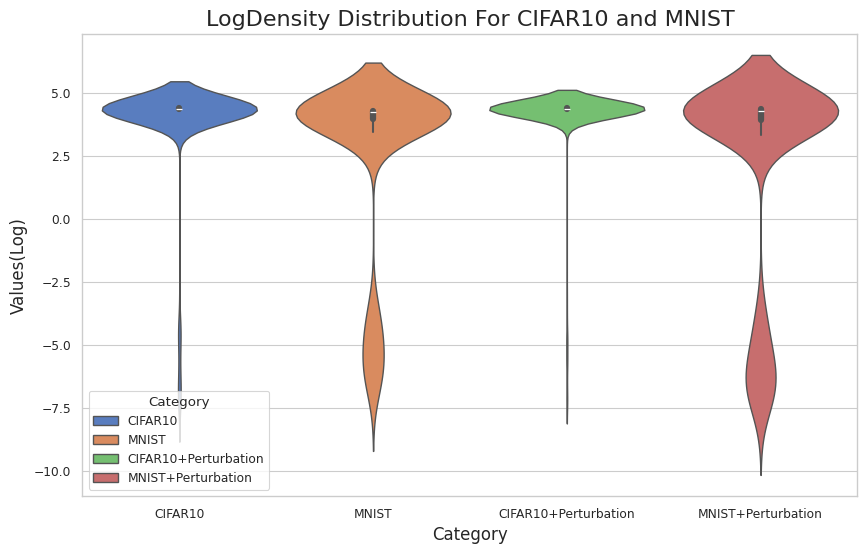

In [125]:
x1= np.sign(logp.cpu().numpy()) * np.log10(np.abs(logp.cpu().numpy()))  # 零值单独处理
x2= np.sign(logp2.cpu().numpy()) * np.log10(np.abs(logp2.cpu().numpy()))  # 零值单独处理
x3= np.sign(ood_logp.cpu().numpy()) * np.log10(np.abs(ood_logp.cpu().numpy()))  # 零值单独处理
x4= np.sign(ood_logp2.cpu().numpy()) * np.log10(np.abs(ood_logp2.cpu().numpy()))  # 零值单独处理
data = {
    "Values": np.concatenate([x1,x3,x2,x4]),
    "Category": np.repeat(['CIFAR10', f'{ood_dataset}', 'CIFAR10+Perturbation', f'{ood_dataset}+Perturbation'],1000)
}
df = pd.DataFrame(data)

# 绘制小提琴图
plt.figure(figsize=(10, 6))
sns.violinplot(x='Category', y='Values', hue='Category', data=df, palette='muted', inner='box', legend=True)
# sns.boxplot(x='Category', y='Values', hue='Category',data=df, palette='muted',showmeans=True,)

# 添加标题和标签
plt.title(f'LogDensity Distribution For CIFAR10 and {ood_dataset}', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Values(Log)', fontsize=12)

plt.savefig(f'pngs/{model}/logdensity_violin_purturbation.png', bbox_inches='tight')

# 显示图表
plt.show()

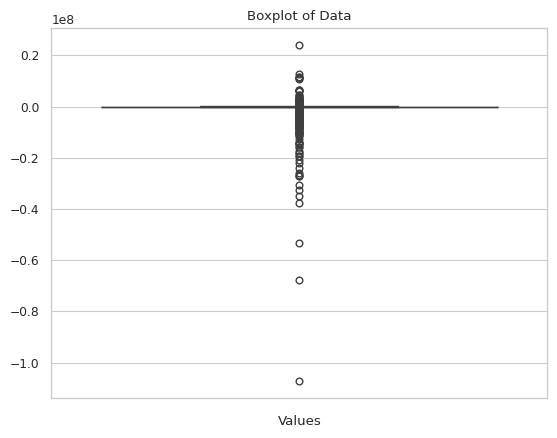

In [126]:
ood_diff = ood_logp2-ood_logp
sns.boxplot(data=ood_diff.cpu().numpy())

# 添加图标题和标签
plt.title("Boxplot of Data")
plt.xlabel("Values")

# 显示图形
plt.show()

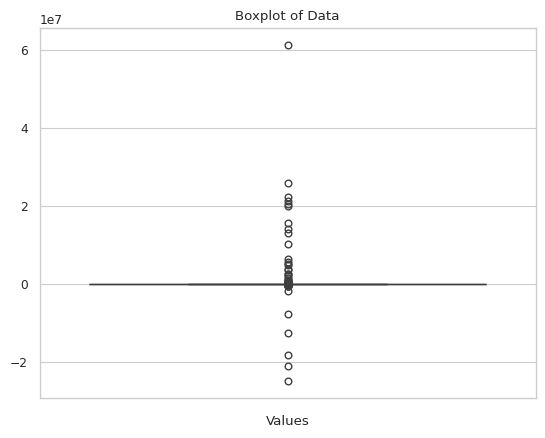

In [127]:
diff = logp2-logp
sns.boxplot(data=diff.cpu().numpy())

# 添加图标题和标签
plt.title("Boxplot of Data")
plt.xlabel("Values")

# 显示图形
plt.show()

In [128]:
diff

tensor([ 1.5506e+04,  1.1428e+03,  1.9751e+03, -2.5982e+03, -2.0281e+03,
        -1.6392e+02, -1.9438e+03,  4.0053e+03,  1.0003e+02,  6.1384e+02,
        -2.2080e+02, -3.1832e+02,  1.0309e+04,  1.5581e+03,  4.2536e+02,
        -8.2422e-01, -6.9117e+01,  3.9494e+02, -3.0880e+02,  5.8050e+02,
         9.5003e+04,  1.1850e+02,  2.6621e+02, -1.1258e+03,  1.4633e+02,
        -1.5902e+01, -1.7070e+01, -7.1426e+02, -2.4062e+04, -8.7711e+01,
         2.6523e+03, -1.4299e+02, -1.0452e+03,  1.7384e+03,  4.1595e+02,
         4.0079e+02,  3.4091e+02,  7.9926e+02, -1.2613e+02,  2.3358e+03,
         3.8048e+02,  4.4928e+01,  4.3045e+02,  3.1345e+02,  2.1958e+03,
         2.7383e+01, -1.8949e+01,  4.4246e+02,  7.1479e+02,  8.7554e+02,
         1.7911e+03,  8.8672e+00,  3.0291e+03,  9.2768e+02, -1.0428e+02,
        -7.0879e+01,  5.4355e+02,  1.3405e+02, -5.8946e+02, -3.4179e+02,
         1.0043e+03,  2.5036e+02,  2.0660e+02,  2.6926e+02,  1.6067e+02,
         4.2882e+02,  2.5907e+03,  6.8397e+02,  1.6

In [129]:
diff[diff<0].shape[0]/1000

0.255

In [130]:
ood_diff

tensor([ 5.2129e+03,  9.1858e+05,  9.8092e+02,  1.0270e+04, -3.6312e+05,
         8.7199e+05,  4.7344e+03,  1.7492e+06,  7.6941e+03,  1.3670e+03,
         7.5254e+00,  3.0052e+03, -3.0530e+03,  1.2642e+03, -8.2831e+06,
         1.3857e+03,  1.0299e+03,  4.0376e+03,  2.0354e+03,  2.7188e+02,
         1.3825e+06, -4.8107e+02,  5.8002e+04,  6.7237e+03,  1.8472e+03,
         5.5687e+03, -6.7734e+06, -1.0380e+07,  9.7167e+03, -1.5617e+07,
        -9.9274e+02, -6.6020e+06,  1.5795e+03,  5.6269e+03, -7.6517e+06,
         4.7100e+03,  4.8603e+03,  1.3056e+03,  3.2238e+03,  1.2068e+04,
        -6.8058e+05,  1.0709e+04,  1.4753e+03,  3.9261e+04, -1.4259e+07,
        -2.3550e+03,  3.7283e+03, -6.7810e+07, -1.1356e+06, -1.4342e+07,
         4.4034e+03,  3.6279e+03,  1.7596e+03,  1.7906e+03, -6.8445e+02,
         2.5412e+03,  1.5038e+06, -2.0772e+03, -4.2037e+05, -2.2364e+03,
         4.3608e+05, -1.2383e+05,  7.3502e+04,  1.2637e+07,  2.0724e+03,
         2.4596e+03,  5.1866e+03,  1.7392e+03,  1.5

In [131]:
ood_diff[ood_diff<0].shape[0]/1000

0.313